# Proyecto Model Fitness
Guía paso a paso con explicaciones breves en cada celda para que cualquiera pueda seguir el análisis.

**Objetivo:** predecir *churn* (abandono), entender variables clave y segmentar clientes.

**Estructura:**
- Carga y EDA
- Preprocesamiento
- Modelado (Logistic Regression & Random Forest)
- Métricas y comparación
- Clustering (dendrograma & K‑Means)
- Conclusiones

###  Paso: Importar librerías
Usamos estas librerías para trabajar con datos (pandas/numpy), graficar (matplotlib/seaborn) y entrenar modelos de ML (scikit‑learn).

In [1]:
import os
import pandas as pd
import numpy as np

RANDOM_STATE = 0

path_candidates = [
    "/datasets/gym_churn_us.csv",  
    "gym_churn_us.csv",            
    "/mnt/data/gym_churn_us.csv"   
]

data_path = next((p for p in path_candidates if os.path.exists(p)), None)
assert data_path is not None, "No encontré el archivo CSV. Ajusta la ruta en 'path_candidates'."

df = pd.read_csv(data_path)
print("Ruta usada:", data_path)
print(df.shape)
df.head()


Ruta usada: /datasets/gym_churn_us.csv
(4000, 14)


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


###  Paso: Estadística descriptiva
Vemos promedios, desviaciones y rangos para darnos una idea de las escalas y posibles atípicos.

In [2]:
print("Tipos de dato:")
print(df.dtypes, "\n")

print("Valores faltantes por columna:")
print(df.isnull().sum(), "\n")

print("Describe (numérico):")
df.describe().T


Tipos de dato:
gender                                 int64
Near_Location                          int64
Partner                                int64
Promo_friends                          int64
Phone                                  int64
Contract_period                        int64
Group_visits                           int64
Age                                    int64
Avg_additional_charges_total         float64
Month_to_end_contract                float64
Lifetime                               int64
Avg_class_frequency_total            float64
Avg_class_frequency_current_month    float64
Churn                                  int64
dtype: object 

Valores faltantes por columna:
gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
Near_Location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
Partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
Promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
Phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
Contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
Group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
Age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
Avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
Month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


###  Paso: Comparar quienes se quedan vs. quienes se van (churn)
Calculamos promedios por grupo de **Churn** para detectar diferencias relevantes.

In [3]:
group_means = df.groupby("Churn").mean(numeric_only=True).T.sort_values(by=[0,1], ascending=False)
group_means


Churn,0,1
Avg_additional_charges_total,158.445715,115.082899
Age,29.976523,26.989632
Contract_period,5.747193,1.728558
Month_to_end_contract,5.283089,1.662582
Lifetime,4.711807,0.990575
Avg_class_frequency_current_month,2.027882,1.044546
Avg_class_frequency_total,2.024876,1.474995
Phone,0.903709,0.902922
Near_Location,0.873086,0.768143
Partner,0.534195,0.355325


###  Paso: Importar librerías
Usamos estas librerías para trabajar con datos (pandas/numpy), graficar (matplotlib/seaborn) y entrenar modelos de ML (scikit‑learn).

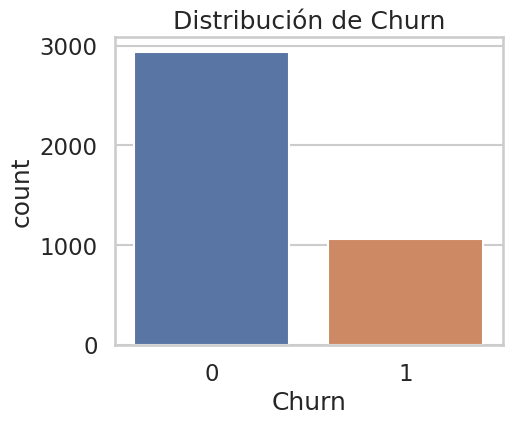

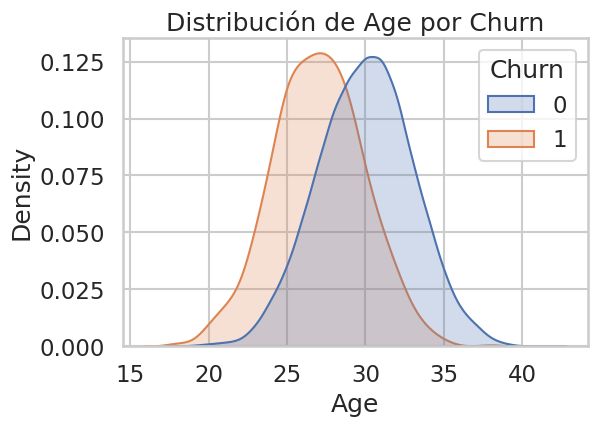

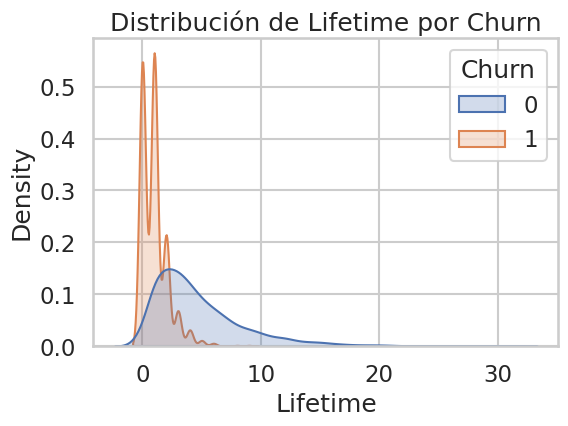

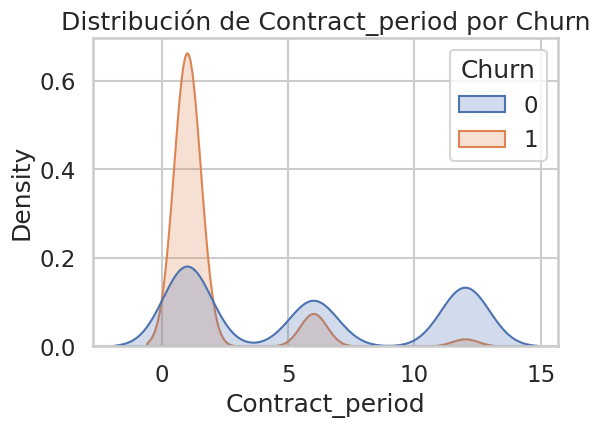

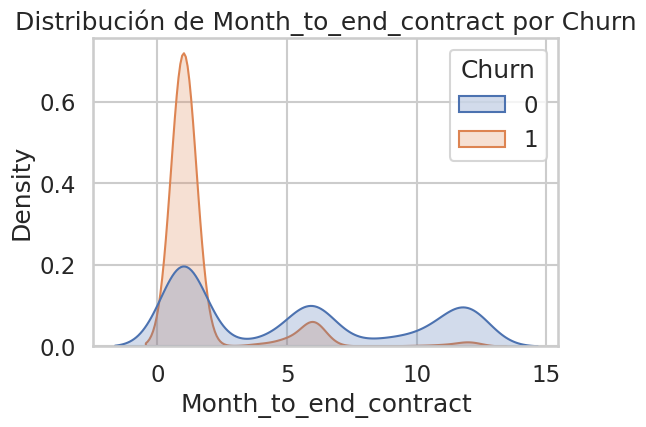

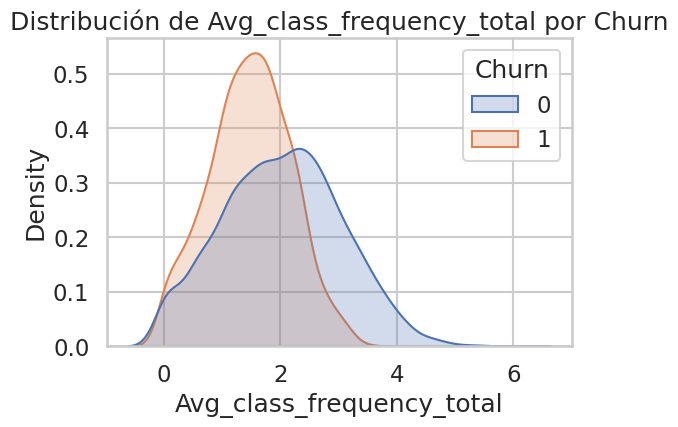

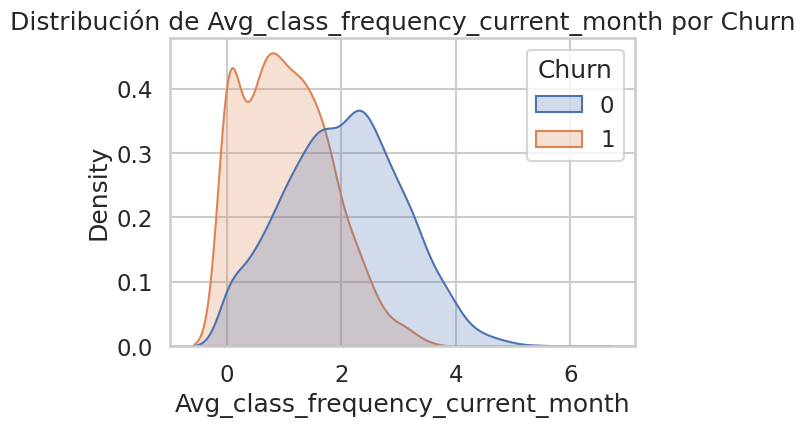

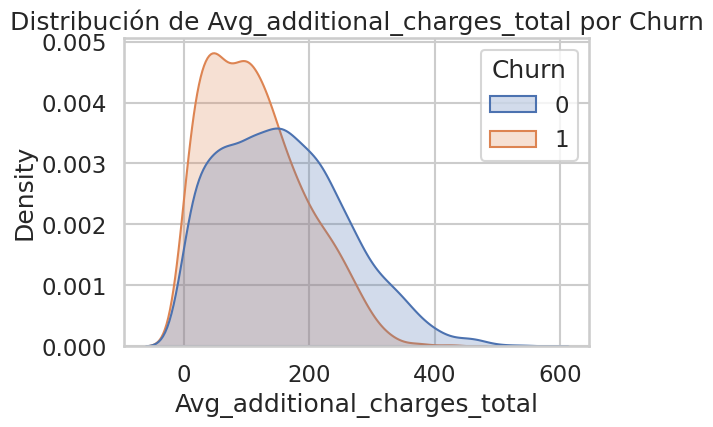

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", context="talk")

plt.figure(figsize=(5,4))
sns.countplot(x="Churn", data=df)
plt.title("Distribución de Churn")
plt.show()

cols_to_plot = [
    "Age", "Lifetime", "Contract_period", "Month_to_end_contract",
    "Avg_class_frequency_total", "Avg_class_frequency_current_month",
    "Avg_additional_charges_total"
]

for col in cols_to_plot:
    plt.figure(figsize=(6,4))
    sns.kdeplot(data=df, x=col, hue="Churn", fill=True, common_norm=False)
    plt.title(f"Distribución de {col} por Churn")
    plt.show()


###  Paso: Matriz de correlación
Medimos qué tan relacionadas están las variables numéricas entre sí y con el objetivo.

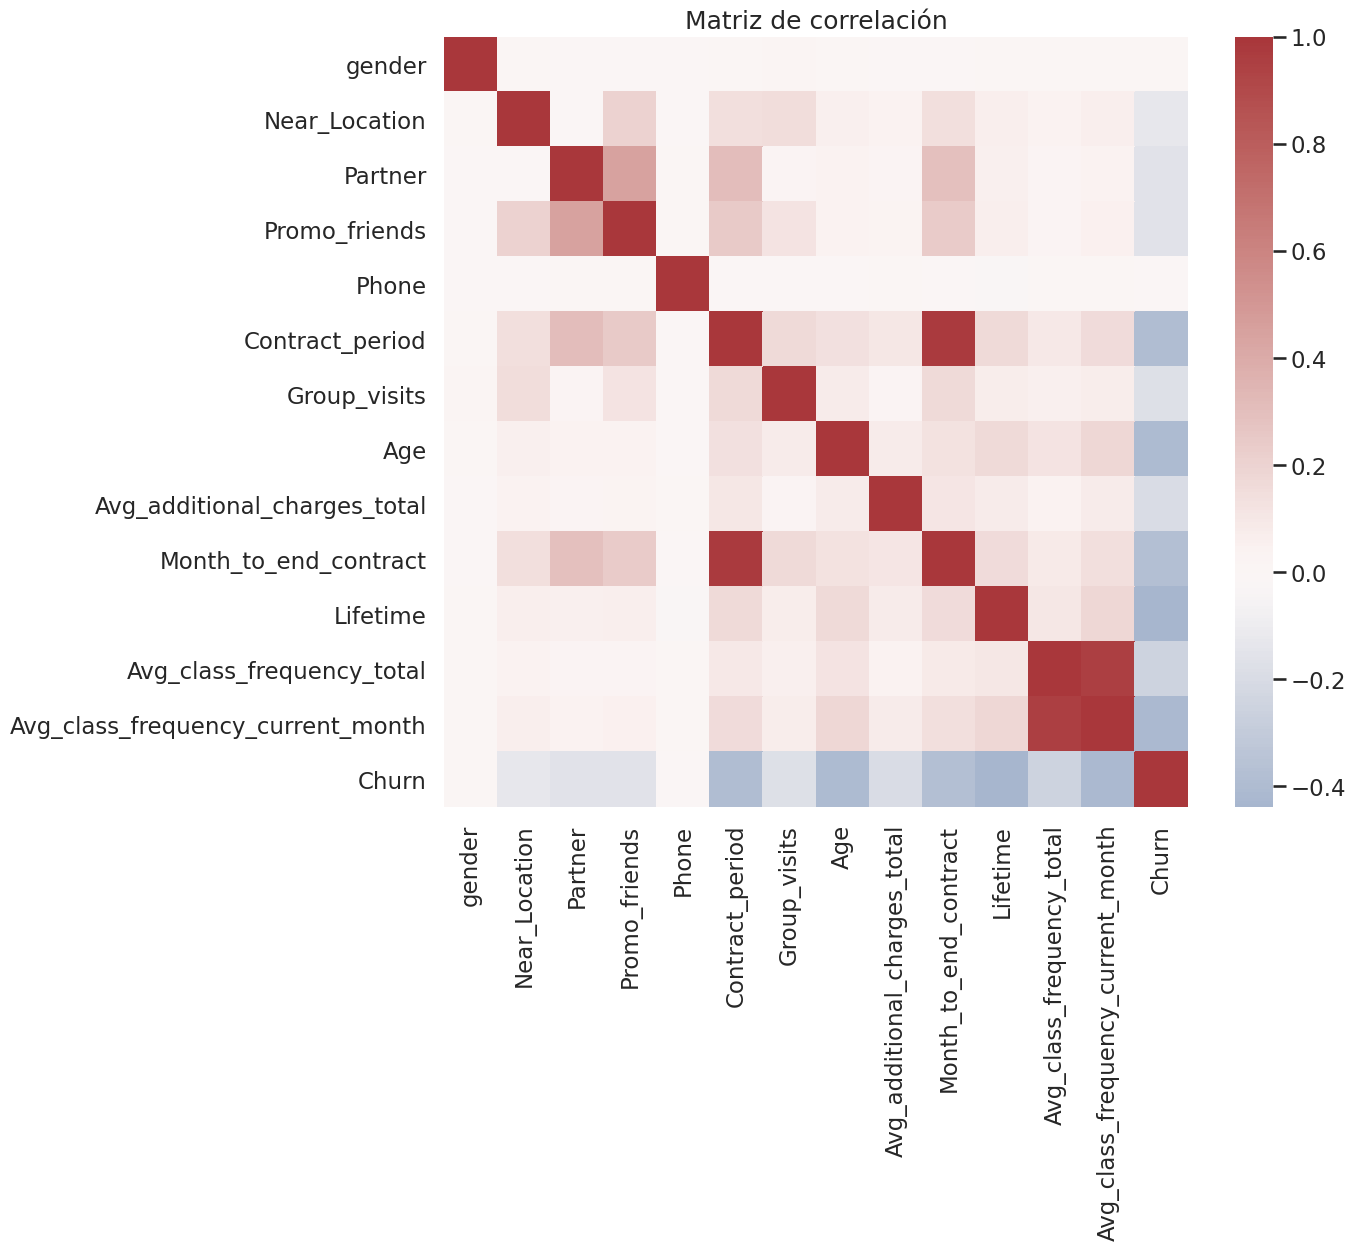

In [7]:
plt.figure(figsize=(12,10))

corr = df.select_dtypes(include=[np.number]).corr()

sns.heatmap(corr, annot=False, cmap="vlag", center=0)
plt.title("Matriz de correlación")
plt.show()


###  Paso: División train/validación
Separamos datos para entrenar el modelo y evaluar su desempeño con datos no vistos.

In [8]:
from sklearn.model_selection import train_test_split

target = "Churn"
features = [c for c in df.columns if c != target]

X = df[features].copy()
y = df[target].copy()

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

X_train.shape, X_val.shape


((3200, 13), (800, 13))

###  Paso: Métricas de clasificación
Calculamos **accuracy, precision, recall (y F1 si aplica)** para comparar modelos y entender fortalezas/debilidades.

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

def evaluar_modelo(model, X_val, y_val, nombre="Modelo"):
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred, zero_division=0)
    rec = recall_score(y_val, y_pred, zero_division=0)
    print(f"=== {nombre} ===")
    print(f"Accuracy : {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall   : {rec:.3f}")
    print("\nClassification report:\n", classification_report(y_val, y_pred, zero_division=0))


###  Paso: Estandarización
Escalamos las variables numéricas para que todas tengan la misma escala y el modelo aprenda mejor.

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

logreg_pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, n_jobs=None))
])

logreg_pipe.fit(X_train, y_train)
evaluar_modelo(logreg_pipe, X_val, y_val, "Regresión Logística")


=== Regresión Logística ===
Accuracy : 0.935
Precision: 0.896
Recall   : 0.854

Classification report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.96       588
           1       0.90      0.85      0.87       212

    accuracy                           0.94       800
   macro avg       0.92      0.91      0.92       800
weighted avg       0.93      0.94      0.93       800



###  Paso: Modelo 2 — Bosque aleatorio
Entrenamos un ensamble de árboles que suele capturar relaciones no lineales.

In [12]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=1,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf.fit(X_train, y_train)
evaluar_modelo(rf, X_val, y_val, "Random Forest")


=== Random Forest ===
Accuracy : 0.926
Precision: 0.881
Recall   : 0.835

Classification report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95       588
           1       0.88      0.83      0.86       212

    accuracy                           0.93       800
   macro avg       0.91      0.90      0.90       800
weighted avg       0.93      0.93      0.93       800



###  Paso: Importancia de variables
Vemos qué variables pesan más en el modelo para explicar las predicciones y diseñar acciones.

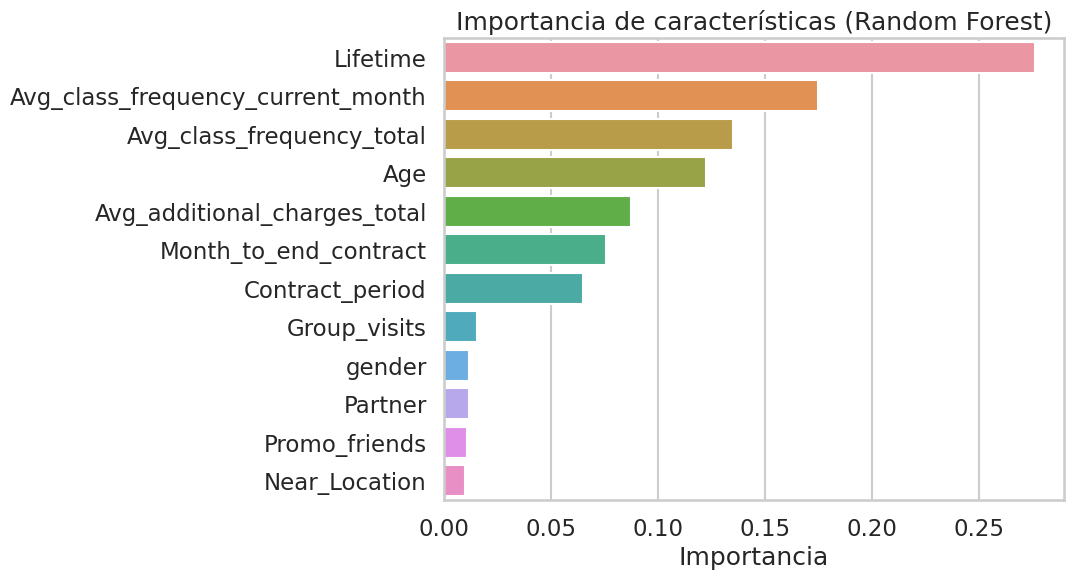

Avg_class_frequency_current_month   -4.213410
Lifetime                            -3.581257
Avg_class_frequency_total            3.111962
Age                                 -1.167067
Contract_period                     -0.703639
Month_to_end_contract               -0.631972
Avg_additional_charges_total        -0.571299
Group_visits                        -0.401414
Promo_friends                       -0.143413
Partner                             -0.066479
Near_Location                       -0.052529
Phone                               -0.022421
dtype: float64

In [13]:
importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(8,6))
sns.barplot(x=importances.head(12), y=importances.head(12).index)
plt.title("Importancia de características (Random Forest)")
plt.xlabel("Importancia")
plt.ylabel("")
plt.show()

clf_log = logreg_pipe.named_steps["clf"]
scaler = logreg_pipe.named_steps["scaler"]

coefs = pd.Series(clf_log.coef_.ravel(), index=features).sort_values(key=np.abs, ascending=False)
coefs.head(12)


###  Paso: Estandarización
Escalamos las variables numéricas para que todas tengan la misma escala y el modelo aprenda mejor.

In [14]:
from sklearn.preprocessing import StandardScaler

X_no_churn = df.drop(columns=[target]).copy()

sc = StandardScaler()
X_sc = sc.fit_transform(X_no_churn)
X_sc.shape


(4000, 13)

###  Paso: Importar librerías
Usamos estas librerías para trabajar con datos (pandas/numpy), graficar (matplotlib/seaborn) y entrenar modelos de ML (scikit‑learn).

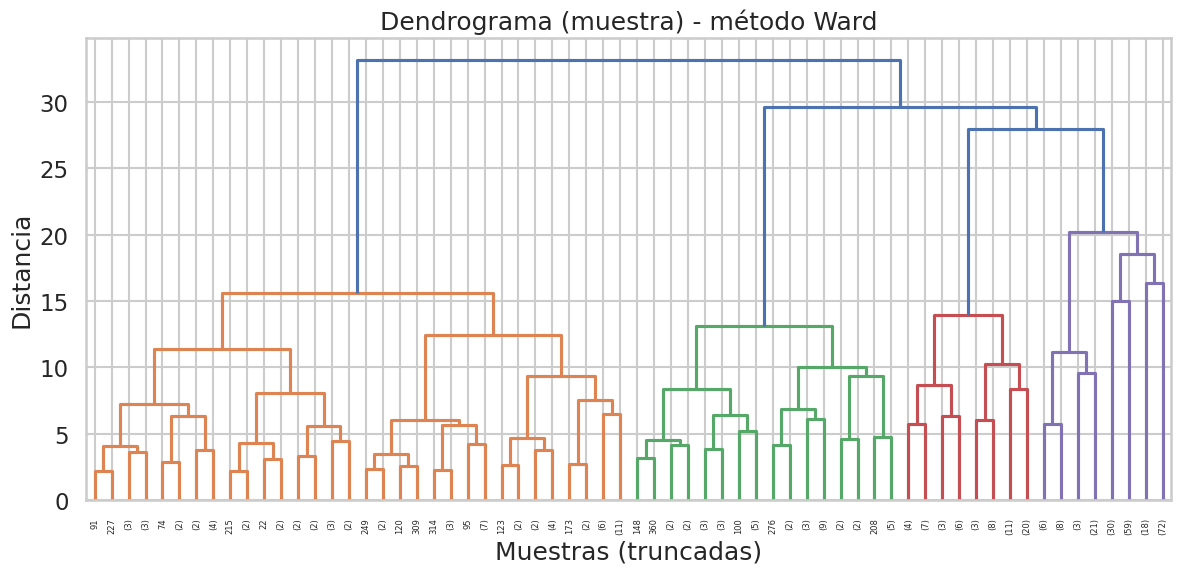

Sugerencia del curso: usar n_clusters = 5 para comparar resultados.


In [15]:
from scipy.cluster.hierarchy import linkage, dendrogram
import numpy as np

np.random.seed(RANDOM_STATE)
sample_idx = np.random.choice(X_sc.shape[0], size=min(400, X_sc.shape[0]), replace=False)
X_sample = X_sc[sample_idx]

linked = linkage(X_sample, method='ward')

plt.figure(figsize=(14, 6))
dendrogram(linked, truncate_mode='level', p=5)  # truncamos para que sea legible
plt.title("Dendrograma (muestra) - método Ward")
plt.xlabel("Muestras (truncadas)")
plt.ylabel("Distancia")
plt.show()

print("Sugerencia del curso: usar n_clusters = 5 para comparar resultados.")


###  Paso: Clustering K‑Means
Agrupamos clientes en **K** clústeres similares para crear segmentos accionables.

In [16]:
from sklearn.cluster import KMeans

k = 5
kmeans = KMeans(n_clusters=k, n_init=20, random_state=RANDOM_STATE)
clusters = kmeans.fit_predict(X_sc)

df_clusters = df.copy()
df_clusters["cluster"] = clusters

means_by_cluster = df_clusters.groupby("cluster").mean(numeric_only=True).round(3)
counts_by_cluster = df_clusters["cluster"].value_counts().sort_index()

counts_by_cluster, means_by_cluster


(0    1010
 1     385
 2     505
 3    1262
 4     838
 Name: cluster, dtype: int64,
          gender  Near_Location  Partner  Promo_friends  Phone  \
 cluster                                                         
 0         0.503          0.959    0.783          0.574  1.000   
 1         0.522          0.862    0.470          0.306  0.000   
 2         0.495          0.000    0.463          0.079  1.000   
 3         0.486          1.000    0.350          0.240  1.000   
 4         0.560          0.976    0.357          0.230  0.999   
 
          Contract_period  Group_visits     Age  Avg_additional_charges_total  \
 cluster                                                                        
 0                 10.889         0.543  29.982                       160.761   
 1                  4.787         0.426  29.301                       143.958   
 2                  2.352         0.216  28.477                       135.458   
 3                  1.948         0.342  28.16

###  Paso: Comparar quienes se quedan vs. quienes se van (churn)
Calculamos promedios por grupo de **Churn** para detectar diferencias relevantes.

In [17]:
churn_rate_by_cluster = df_clusters.groupby("cluster")["Churn"].mean().round(3)
churn_rate_by_cluster


cluster
0    0.028
1    0.268
2    0.444
3    0.514
4    0.068
Name: Churn, dtype: float64

###  Paso: ¿Qué hace este bloque?
Ejecutamos una acción específica (cálculo, gráfico o modelo). Lo dejamos documentado para entender el flujo del análisis.

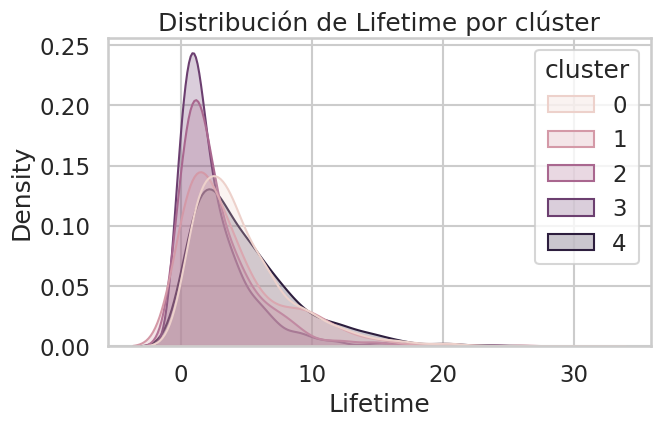

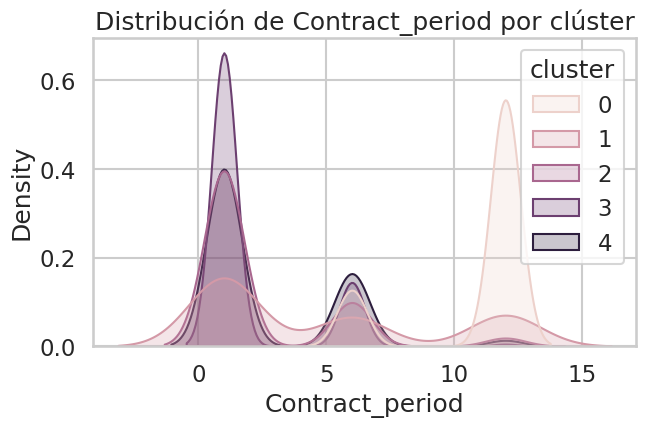

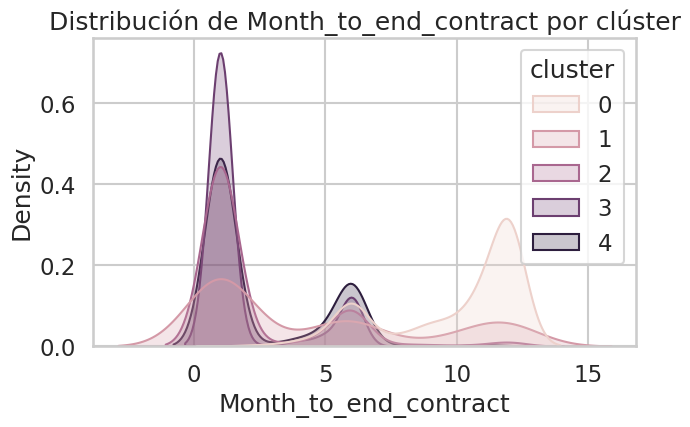

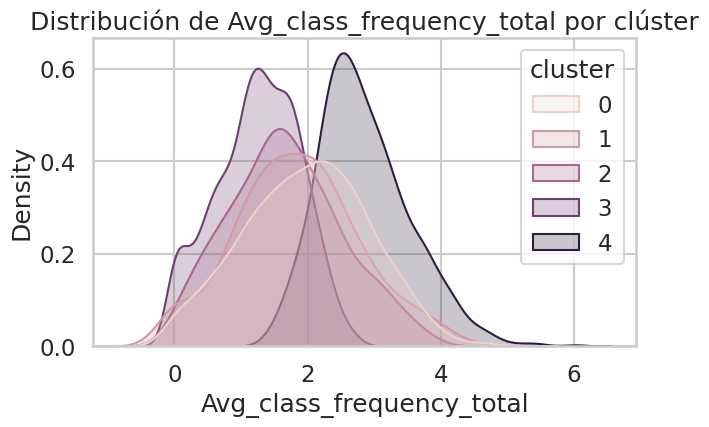

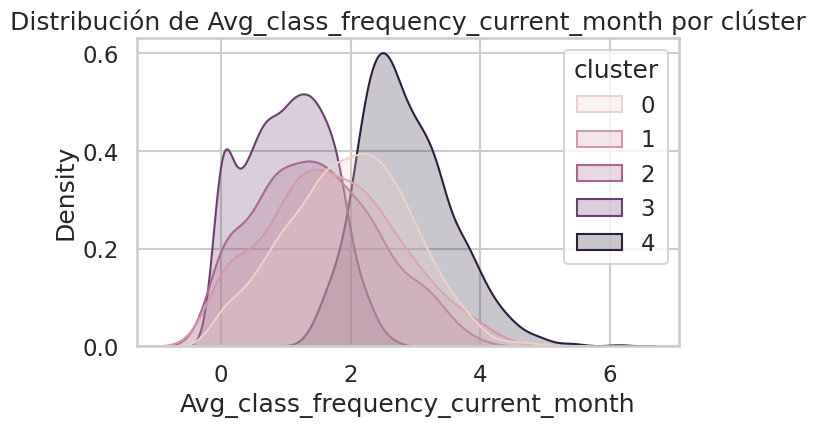

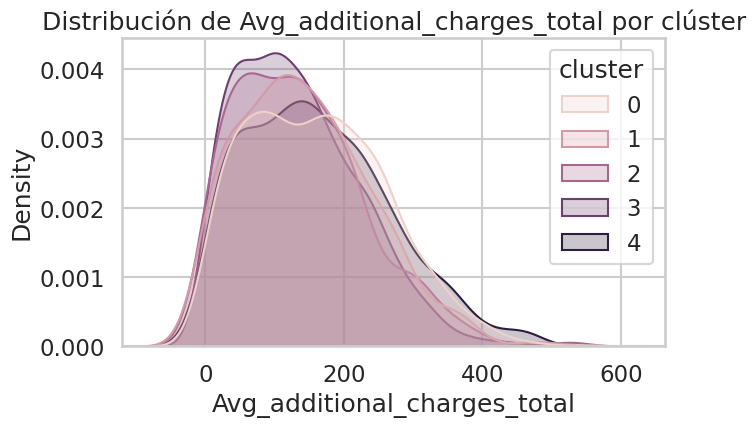

In [18]:
cols_for_cluster_plots = [
    "Lifetime", "Contract_period", "Month_to_end_contract",
    "Avg_class_frequency_total", "Avg_class_frequency_current_month",
    "Avg_additional_charges_total"
]

for col in cols_for_cluster_plots:
    plt.figure(figsize=(7,4))
    sns.kdeplot(data=df_clusters, x=col, hue="cluster", fill=True, common_norm=False)
    plt.title(f"Distribución de {col} por clúster")
    plt.show()



# Conclusiones y Recomendaciones

## 1) Hallazgos del modelo de cancelación
- **Mejor modelo:** (completa) — compara accuracy/precision/recall.
- **Variables más influyentes:** (completa con importancias del RF y/o coeficientes de la logística).
- **Riesgos/limitaciones:** (ej. desbalanceo, fuga de datos, supuestos de estacionalidad, etc.).

## 2) Segmentación (clustering)
- **Segmentos (K=5):** resume rasgos clave por clúster (edad, frecuencia histórica vs. actual, gasto adicional, periodo de contrato, etc.).
- **Tasa de cancelación por clúster:** identifica los grupos con mayor riesgo de churn y los más leales.

## 3) Recomendaciones de retención (ejemplos concretos)
- **Contratos cortos / poco tiempo restante**: ofrecer renovación anticipada con descuento o meses gratis a clientes de alto riesgo.
- **Caída reciente de frecuencia**: disparar campañas proactivas (push/email) con clases guiadas, retos semanales o pases invitados.
- **Bajo gasto adicional pero alta asistencia**: cross-sell de servicios (entrenador personal, nutrición) con prueba gratuita.
- **Leales de alto valor**: programa VIP (beneficios exclusivos, lockers reservados, early access a clases).

## 4) Próximos pasos
- Entrenar con más datos (nuevos meses) y monitorizar drift.
- Calibrar umbral de decisión según objetivos (max precision vs max recall).
- A/B test de campañas por clúster y medir impacto en churn.
"""
    display(Markdown(texto))

conclusiones_y_recomendaciones()
